In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [59]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [21]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
#checked null values and cleaned up
totalmeasures=session.execute("Select count(*) From Measurement").fetchall()
totalstations=session.execute("Select count(*) From Station").fetchall()
nullmeasures=session.execute("Select count(*) From Measurement Where Station is Null").fetchall()
nulldates=session.execute("Select count(*) From Measurement Where Date is Null").fetchall()
nullprcp=session.execute("Select count(*) From Measurement Where Prcp is Null").fetchall()
print(totalmeasures)
print(totalstations)
print(nullmeasures)
print(nulldates)
print(nullprcp)
session.execute("Update Measurement Set Prcp=0.0 Where Prcp is Null")
session.commit()
confirm_nonullprcp=session.execute("Select count(*) From Measurement Where Prcp is Null").fetchall()
print(confirm_nonullprcp)

[(19550,)]
[(9,)]
[(0,)]
[(0,)]
[(0,)]
[(0,)]


In [27]:
# Calculate the date 1 year ago from the last data point in the database
mostrecent = session.execute("Select Max(Date) From Measurement").fetchall()
mostrecent_date=mostrecent[0][0]
print(mostrecent_date)

2017-08-23


In [32]:
yearago = dt.date(2017,8,23) - dt.timedelta(days=365)
print(yearago)

2016-08-23


In [39]:
# Perform a query to retrieve the data and precipitation scores
precipitation = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date <= mostrecent_date).filter(Measurement.date >= yearago).order_by(Measurement.date.desc()).all()
for data in precipitation:
    print(data)

('2017-08-23', 0.0)
('2017-08-23', 0.0)
('2017-08-23', 0.08)
('2017-08-23', 0.45)
('2017-08-22', 0.0)
('2017-08-22', 0.0)
('2017-08-22', 0.5)
('2017-08-21', 0.0)
('2017-08-21', 0.02)
('2017-08-21', 0.0)
('2017-08-21', 0.56)
('2017-08-20', 0.0)
('2017-08-20', 0.01)
('2017-08-20', 0.0)
('2017-08-19', 0.0)
('2017-08-19', 0.0)
('2017-08-19', 0.0)
('2017-08-19', 0.09)
('2017-08-18', 0.0)
('2017-08-18', 0.0)
('2017-08-18', 0.06)
('2017-08-18', 0.0)
('2017-08-17', 0.0)
('2017-08-17', 0.05)
('2017-08-17', 0.01)
('2017-08-17', 0.13)
('2017-08-16', 0.0)
('2017-08-16', 0.07)
('2017-08-16', 0.12)
('2017-08-16', 0.42)
('2017-08-15', 0.02)
('2017-08-15', 0.0)
('2017-08-15', 0.06)
('2017-08-15', 0.32)
('2017-08-15', 0.42)
('2017-08-14', 0.0)
('2017-08-14', 0.01)
('2017-08-14', 0.08)
('2017-08-14', 0.0)
('2017-08-14', 0.22)
('2017-08-13', 0.0)
('2017-08-13', 0.0)
('2017-08-13', 0.0)
('2017-08-13', 0.0)
('2017-08-13', 0.0)
('2017-08-12', 0.0)
('2017-08-12', 0.0)
('2017-08-12', 0.14)
('2017-08-11', 0.0)

In [48]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(precipitation)
precipitation_df.set_index('date', inplace=True)
precipitation_df.head()
# Sort the dataframe by date

,prcp
date,
2017-08-23,0.00
2017-08-23,0.00
2017-08-23,0.08
2017-08-23,0.45
2017-08-22,0.00


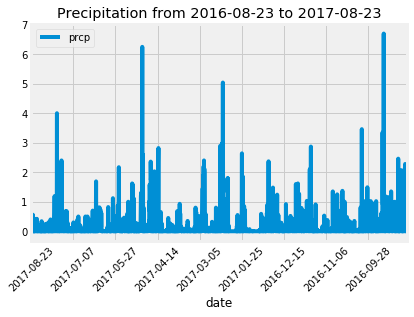

In [87]:
# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(title=f"Precipitation from {yearago} to {mostrecent_date}", rot=45)
plt.savefig("Images/precipitation.png")

![precipitation](Images/precipitation.png)

In [51]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()


,prcp
count,2230.000000
mean,0.160664
std,0.442067
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,6.700000


![describe](Images/describe.png)

In [53]:
# Design a query to show how many stations are available in this dataset?
totalstations_count = totalstations[0][0]
print(totalstations_count)

9


In [60]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
mostactive = session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).order_by(desc(func.count(Measurement.station))).all()
for station in mostactive:
    print(station)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [67]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
mostactive_station = session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).order_by(desc(func.count(Measurement.station))).first()
mostactive_stationID = mostactive_station[0]
print(mostactive_stationID)
session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).filter(Measurement.station == mostactive_stationID).all()

USC00519281


[(54.0, 85.0, 71.66378066378067)]

In [75]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station 
mostactive_station_yearobs = session.query(Measurement.date, Measurement.station, Measurement.tobs).filter(Measurement.date <= mostrecent_date).filter(Measurement.date >= yearago).filter(Measurement.station == mostactive_stationID).order_by(desc(Measurement.date)).all()
for date in mostactive_station_yearobs:
    print(date)

('2017-08-18', 'USC00519281', 79.0)
('2017-08-17', 'USC00519281', 76.0)
('2017-08-16', 'USC00519281', 76.0)
('2017-08-15', 'USC00519281', 77.0)
('2017-08-14', 'USC00519281', 77.0)
('2017-08-13', 'USC00519281', 77.0)
('2017-08-06', 'USC00519281', 83.0)
('2017-08-05', 'USC00519281', 82.0)
('2017-08-04', 'USC00519281', 77.0)
('2017-07-31', 'USC00519281', 76.0)
('2017-07-30', 'USC00519281', 81.0)
('2017-07-29', 'USC00519281', 82.0)
('2017-07-28', 'USC00519281', 81.0)
('2017-07-27', 'USC00519281', 76.0)
('2017-07-26', 'USC00519281', 75.0)
('2017-07-25', 'USC00519281', 77.0)
('2017-07-24', 'USC00519281', 75.0)
('2017-07-23', 'USC00519281', 82.0)
('2017-07-22', 'USC00519281', 77.0)
('2017-07-21', 'USC00519281', 77.0)
('2017-07-20', 'USC00519281', 77.0)
('2017-07-19', 'USC00519281', 76.0)
('2017-07-18', 'USC00519281', 76.0)
('2017-07-17', 'USC00519281', 76.0)
('2017-07-16', 'USC00519281', 80.0)
('2017-07-15', 'USC00519281', 80.0)
('2017-07-14', 'USC00519281', 76.0)
('2017-07-13', 'USC00519281'

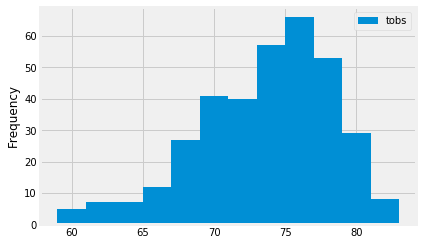

In [88]:
# and plot the results as a histogram with bins=12
mostactive_station_yearobs_df = pd.DataFrame(mostactive_station_yearobs)
#mostactive_station_yearobs_df.head()
mostactive_station_yearobs_df.plot.hist(by='tobs',bins=12)
plt.savefig("Images/active_station_temps.png")

![precipitation](Images/station-histogram.png)

In [73]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [79]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
tripavgtemp = calc_temps(yearago, mostrecent_date)
print(tripavgtemp)

[(58.0, 74.59058295964125, 87.0)]


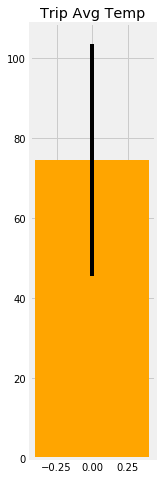

In [89]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
tmin = tripavgtemp[0][0]
tave = tripavgtemp[0][1]
tmax = tripavgtemp[0][2]
yerr = tmax - tmin

plt.figure(figsize=(2,8))
plt.bar(0,tave,yerr=yerr,align="center",color="orange")
plt.title("Trip Avg Temp")
plt.savefig("Images/Trip_Avg_Temp.png")

In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


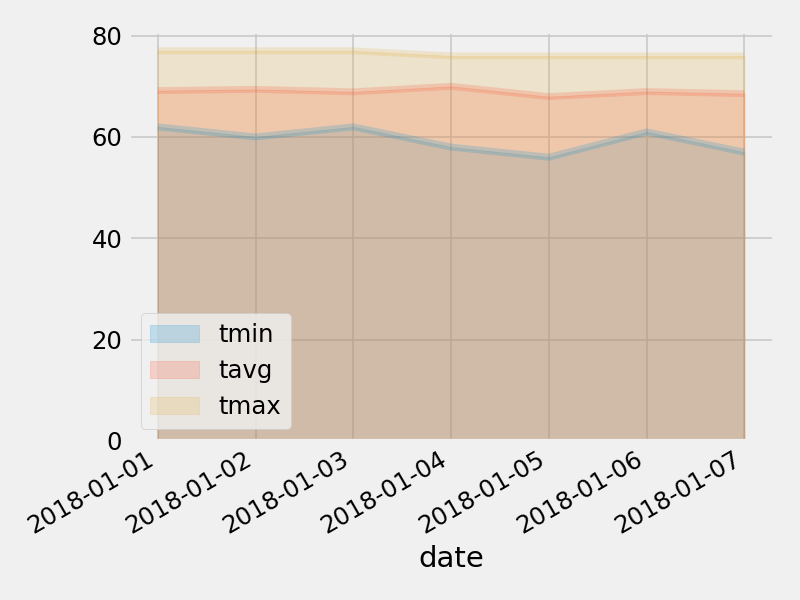

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
